In [32]:
import argparse
import cmasher as cmr
from functools import partial
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy.spatial
from scipy.spatial.transform import Rotation
from scipy.stats import median_abs_deviation, binned_statistic
from sklearn.ensemble import RandomForestRegressor
import sys
from tqdm import tqdm
from pathlib import Path
import illustris_python as il

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.utils as pyg_utils
from torch_geometric.nn import (
    MessagePassing, GCNConv, PPFConv, MetaLayer, EdgeConv,
    global_mean_pool, global_max_pool, global_add_pool
)
from torch_cluster import radius_graph

In [2]:

ROOT = Path("..").resolve()
tng_base_path = f"{ROOT}/illustris_data/TNG300-1/output"

seed = 255
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

device = "cuda" if torch.cuda.is_available() else "cpu"

### params for generating data products, visualizations, etc.
recompile_data = False
retrain = False
revalidate = False
make_plots = True
save_models = True

### simulation and selection criteria params
use_gal = True # gal -> dark matter, or vice versa

In [14]:
cuts = {
    "minimum_log_stellar_mass": 9.5,
    "minimum_log_halo_mass": 11,
    "minimum_n_star_particles": 50
}

snapshot = 99 # z=0
h = 0.6774    # Planck 2015 cosmology

### training and optimization params
batch_size = 36

training_params = dict(
    batch_size=batch_size,
    learning_rate=1e-2,
    weight_decay=1e-4,
    n_epochs=500,
)

config_params = dict(
    boxsize=302.6e3,    # box size in comoving kpc/h
    h_reduced=0.6774,   # reduced Hubble constant
    snapshot=99,       # z = 0
)

normalization_params = dict(
    minimum_n_star_particles=50., # min star particles to be considered a galaxy
    norm_half_mass_radius=8., 
    norm_velocity=100., # note: use value of 1 if `use_central_galaxy_frame=True`
)


feature_params = dict(
    use_stellarhalfmassradius=True,
    use_velocity=True,
    use_only_positions=False,
    use_central_galaxy_frame=False, # otherwise use center of mass frame
    in_projection=True, # only use projected positions and radial velocity
)

split = 6 
train_test_frac_split = split**2

undirected = True
periodic = False

r_link = 5
pad = 2.5

in_projection = False
use_loops = True

In [15]:
use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz','subhalo_logstellarmass', 'subhalo_logstellarhalfmassradius']
y_cols = ['subhalo_loghalomass']


if in_projection:
    for c in ['subhalo_z', 'subhalo_vx', 'subhalo_vy']:
        use_cols.remove(c)

subhalo_fields = [
    "SubhaloPos", "SubhaloMassType", "SubhaloLenType", "SubhaloHalfmassRadType", 
    "SubhaloVel", "SubhaloVmax", "SubhaloGrNr", "SubhaloFlag"
]
subhalos = il.groupcat.loadSubhalos(tng_base_path, snapshot, fields=subhalo_fields) 

pos = subhalos["SubhaloPos"][:,:3]
min_box, max_box = np.rint(np.min(pos)), np.rint(np.max(pos))
box_size = max_box/(h*1e3) # in Mpc

halo_fields = ["Group_M_Crit200", "GroupFirstSub", "GroupPos", "GroupVel"]
halos = il.groupcat.loadHalos(tng_base_path, snapshot, fields=halo_fields)

subhalo_pos = subhalos["SubhaloPos"][:] / (h*1e3)
subhalo_stellarmass = subhalos["SubhaloMassType"][:,4]
subhalo_halomass = subhalos["SubhaloMassType"][:,1]
subhalo_n_stellar_particles = subhalos["SubhaloLenType"][:,4]
subhalo_stellarhalfmassradius = subhalos["SubhaloHalfmassRadType"][:,4]  / normalization_params["norm_half_mass_radius"]
subhalo_vel = subhalos["SubhaloVel"][:] /  normalization_params["norm_velocity"]
subhalo_vmax = subhalos["SubhaloVmax"][:] / normalization_params["norm_velocity"]
subhalo_flag = subhalos["SubhaloFlag"][:]
halo_id = subhalos["SubhaloGrNr"][:].astype(int)

halo_mass = halos["Group_M_Crit200"][:]
halo_primarysubhalo = halos["GroupFirstSub"][:].astype(int)
group_pos = halos["GroupPos"][:] / (h*1e3)
group_vel = halos["GroupVel"][:]  / normalization_params["norm_velocity"]

halos = pd.DataFrame(
    np.column_stack((np.arange(len(halo_mass)), group_pos, group_vel, halo_mass, halo_primarysubhalo)),
    columns=['halo_id', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mass', 'halo_primarysubhalo']
)
halos['halo_id'] = halos['halo_id'].astype(int)
halos.set_index("halo_id", inplace=True)

# get subhalos/galaxies      
subhalos = pd.DataFrame(
    np.column_stack([halo_id, subhalo_flag, np.arange(len(subhalo_stellarmass)), subhalo_pos, subhalo_vel, subhalo_n_stellar_particles, subhalo_stellarmass, subhalo_halomass, subhalo_stellarhalfmassradius, subhalo_vmax]), 
    columns=['halo_id', 'subhalo_flag', 'subhalo_id', 'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass', 'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax'],
)
subhalos["is_central"] = (halos.loc[subhalos.halo_id]["halo_primarysubhalo"].values == subhalos["subhalo_id"].values)

subhalos = subhalos[subhalos["subhalo_flag"] != 0].copy()
subhalos['halo_id'] = subhalos['halo_id'].astype(int)
subhalos['subhalo_id'] = subhalos['subhalo_id'].astype(int)

subhalos.drop("subhalo_flag", axis=1, inplace=True)

# impose stellar mass and particle cuts
subhalos = subhalos[subhalos["subhalo_n_stellar_particles"] > cuts["minimum_n_star_particles"]].copy()
subhalos["subhalo_logstellarmass"] = np.log10(subhalos["subhalo_stellarmass"] / h)+10

subhalos["subhalo_loghalomass"] = np.log10(subhalos["subhalo_halomass"] / h)+10
subhalos["subhalo_logvmax"] = np.log10(subhalos["subhalo_vmax"])
subhalos["subhalo_logstellarhalfmassradius"] = np.log10(subhalos["subhalo_stellarhalfmassradius"])

subhalos = subhalos[subhalos["subhalo_loghalomass"] > cuts["minimum_log_halo_mass"]].copy()

subhalos = subhalos[subhalos["subhalo_logstellarmass"] > cuts["minimum_log_stellar_mass"]].copy()

data = []
for n in tqdm(range(split), position=0):
    for g in tqdm(range(split), position=1, leave=False):
        for k in tqdm(range(split), position=2, leave=False):
            # print(n,g,k)
            xlims = np.array([box_size/split*n+pad, box_size/split*(n+1)-pad])
            ylims = np.array([box_size/split*g+pad, box_size/split*(g+1)-pad])
            zlims = np.array([box_size/split*k+pad, box_size/split*(k+1)-pad])

            pos = np.vstack(subhalos[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

            xmask = np.logical_and(pos[:,0]>xlims[0],pos[:,0]<xlims[1])
            ymask = np.logical_and(pos[:,1]>ylims[0],pos[:,1]<ylims[1])
            zmask = np.logical_and(pos[:,2]>zlims[0],pos[:,2]<zlims[1])
            mask = np.logical_and(zmask, np.logical_and(xmask, ymask))

            df = subhalos.iloc[mask].copy()
            df.reset_index(drop=True)

            # remove extraneous columns
            df.drop(["subhalo_n_stellar_particles", "subhalo_stellarmass", "subhalo_halomass"], axis=1, inplace=True)

            # set new zero point

            df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']] - np.array([box_size/split*n+pad, box_size/split*g+pad, box_size/split*k+pad])

            #make positions for clustering

            if in_projection:
                pos = np.vstack(df[['subhalo_x', 'subhalo_y']].to_numpy())    
            else:
                pos = np.vstack(df[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

            kd_tree = scipy.spatial.KDTree(pos, leafsize=25, boxsize=box_size)
            edge_index = kd_tree.query_pairs(r=r_link, output_type="ndarray")

            # normalize positions

            df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']]/(box_size/2)

            if undirected:
            # Add reverse pairs
                reversepairs = np.zeros((edge_index.shape[0],2))
                for i, pair in enumerate(edge_index):
                    reversepairs[i] = np.array([pair[1], pair[0]])
                edge_index = np.append(edge_index, reversepairs, 0)

                edge_index = edge_index.astype(int)

                # Write in pytorch-geometric format
                edge_index = edge_index.reshape((2,-1))
                num_pairs = edge_index.shape[1]

            row, col = edge_index

            diff = pos[row]-pos[col]
            dist = np.linalg.norm(diff, axis=1)

            use_gal = True

            if periodic:
                # Take into account periodic boundary conditions, correcting the distances
                for i, pos_i in enumerate(diff):
                    for j, coord in enumerate(pos_i):
                        if coord > r_link:
                            diff[i,j] -= box_size  # Boxsize normalize to 1
                        elif -coord > r_link:
                            diff[i,j] += box_size  # Boxsize normalize to 1

            centroid = np.mean(pos,axis=0) # define arbitrary coordinate, invarinat to translation/rotation shifts, but not stretches
            # centroid+=1.2

            unitrow = (pos[row]-centroid)/np.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
            unitcol = (pos[col]-centroid)/np.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
            unitdiff = diff/dist.reshape(-1,1)
            # Dot products between unit vectors
            cos1 = np.array([np.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])
            cos2 = np.array([np.dot(unitrow[i,:].T,unitdiff[i,:]) for i in range(num_pairs)])

            edge_attr = np.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1)], axis=1)

            if use_loops:
                loops = np.zeros((2,pos.shape[0]),dtype=int)
                atrloops = np.zeros((pos.shape[0], edge_attr.shape[1]))
                for i, posit in enumerate(pos):
                    loops[0,i], loops[1,i] = i, i
                    atrloops[i,0], atrloops[i,1], atrloops[i,2] = 0., 1., 0.
                edge_index = np.append(edge_index, loops, 1)
                edge_attr = np.append(edge_attr, atrloops, 0)
            edge_index = edge_index.astype(int)

            x = torch.tensor(np.vstack(df[use_cols].to_numpy()), dtype=torch.float)
            y = torch.tensor(np.vstack(df[y_cols].to_numpy()), dtype=torch.float)
            edge_index = torch.tensor(edge_index, dtype=torch.long)
            edge_attr=torch.tensor(edge_attr, dtype=torch.float)
            pos = torch.tensor(pos, dtype=torch.float)
            is_central = torch.tensor(df.is_central.values, dtype=bool)

            data.append(Data(x=x, y=y, pos=pos, is_central=is_central, edge_index=edge_index, edge_attr=edge_attr))

            proj_str = "-projected" if in_projection else ""

/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 0/6 [00:00<?, ?it/s]






























 17%|█▋        | 1/6 [00:03<00:17,  3.52s/it]

































 33%|███▎      | 2/6 [00:07<00:15,  3.79s/it]





























 50%|█████     | 3/6 [00:11<00:11,  3.71s/it]































 67%|██████▋   | 4/6 [00:14<00:07,  3.61s/it]






























 83%|████████▎ | 5/6 [00:18<00:03,  3.61s/it]





























100%|██████████| 6/6 [00:21<00:00,  3.62s/it]


# Experiment with dropping out as function of mass and mass surface density

In [16]:
# log stellar mass
data[0].x[:, -2]

tensor([10.6087, 10.8298, 11.8352, 10.9678, 10.4896, 10.0492,  9.7174,  9.7576,
         9.8507, 10.0948, 11.6245, 10.5911, 10.2377, 10.1215,  9.9190, 11.5560,
        10.6659, 10.0677, 10.5285, 10.3642, 10.4345,  9.8958, 11.3597, 11.2407,
        10.4839, 11.0965,  9.7187, 10.1397,  9.7340, 11.2504, 10.3569, 10.8973,
         9.9053,  9.8629, 11.0740, 10.7941, 10.7372, 10.2634, 10.4203, 10.3237,
        10.9403, 10.8238,  9.9415, 10.6900, 10.2803, 10.7206, 10.4743,  9.8698,
        10.2277,  9.6900, 10.7579, 10.2831, 11.0194, 10.8847, 10.4707, 10.6284,
         9.5417, 10.3987, 10.1388,  9.9635,  9.7607, 10.9510, 10.6182, 10.4422,
        10.0653, 10.8737, 10.6464,  9.6419, 10.4387,  9.9181, 10.6317, 10.3779,
        10.1589, 10.7948, 10.3812, 10.5825, 10.6883, 10.5227, 10.4504, 10.3705,
        10.2464, 10.4912, 10.5658, 10.5573, 10.2256, 10.3356, 10.1828, 10.5944,
        10.6201, 10.1215,  9.8916, 10.2823, 10.2934, 10.4073, 10.3584, 10.3171,
        10.3580,  9.8846,  9.8204, 10.28

In [17]:

# log stellar half mass radius
# np.log10(10**data[0].x[:, -1] * normalization_params["norm_half_mass_radius"] * h)

# log SB
data[0].x[:, -2] - 2 * np.log10(10**data[0].x[:, -1] * normalization_params["norm_half_mass_radius"] * h) - np.log10(np.pi)

tensor([9.1491, 9.1745, 8.7517, 9.7456, 9.3536, 9.2711, 8.5244, 8.5726, 8.6843,
        9.1885, 8.8989, 9.3638, 9.0219, 9.2416, 8.6116, 9.3079, 9.3199, 8.7522,
        9.1270, 9.2231, 9.1943, 8.7784, 9.0321, 9.2790, 9.2931, 9.2798, 8.6493,
        8.9238, 8.3279, 9.1809, 9.2971, 9.1955, 8.7443, 8.4186, 9.2008, 9.5800,
        9.3310, 9.3173, 9.3778, 8.7574, 9.2063, 9.1390, 8.9460, 9.1404, 9.2486,
        9.0372, 9.1370, 8.7049, 9.3620, 8.6780, 9.1496, 9.2545, 9.2338, 9.1756,
        9.3655, 9.2787, 8.7590, 9.6822, 9.0048, 9.0140, 8.6145, 9.2909, 8.7695,
        9.1647, 8.4399, 9.5135, 9.1969, 8.4413, 9.2685, 8.5505, 9.0666, 8.6201,
        8.0761, 9.2164, 9.3647, 9.2649, 9.5051, 9.4728, 9.1155, 9.2333, 9.2427,
        9.4818, 9.2391, 9.1712, 9.1193, 9.4847, 9.0837, 9.5716, 9.3393, 9.1852,
        8.9191, 8.8337, 8.5703, 9.2942, 9.0841, 9.0783, 9.2770, 8.6350, 8.5409,
        9.1950, 9.3017, 9.4708, 9.2724, 8.9405, 9.2624, 8.9920, 9.1753, 9.2070,
        9.1456, 9.2947, 9.2550, 8.9510, 

In [18]:
def drop_low_mass(datum, mass_threshold=10.0, sigmoid_width=0.03, rgn=None):
    """Drops out galaxies with a mass below the mass threshold, but using a probability 
    that is 50% at the threshold and has a sigmoid function (logistic function) width 
    equal as specified (default 0.03 for a mass threshold of 10).
    """

    if rng is None:
        rng = np.random.RandomState(42)
        
    dropout_prob = 1 / (1 + torch.exp((mass_threshold - datum.x[:, -2]) / sigmoid_width))
    subset = torch.tensor(rng.uniform(size=len(datum.x))) < dropout_prob

    new_edge_index, new_edge_attr = pyg_utils.subgraph(
        subset=subset,
        edge_index=datum.edge_index,
        edge_attr=datum.edge_attr,
    )

    return Data(
        x=datum.x[subset], 
        y=datum.y[subset], 
        pos=datum.pos[subset], 
        edge_index=new_edge_index, 
        edge_attr=new_edge_attr, 
        is_central=datum.is_central[subset]
    )

def drop_low_surface_brightness(datum, sb_threshold=8.5, sigmoid_width=0.03, rng=None):
    """Drops out galaxies with a SB below the log sb threshold, but using a probability 
    that is 50% at the threshold and has a sigmoid function (logistic function) width 
    equal as specified (default 0.03 for a mass threshold of 10).
    """

    if rng is None:
        rng = np.random.RandomState(42)

    sb = datum.x[:, -2] - 2 * np.log10(10**datum.x[:, -1] * normalization_params["norm_half_mass_radius"] * h) - np.log10(np.pi)
    dropout_prob = 1 / (1 + torch.exp((sb_threshold - sb) / sigmoid_width))
    subset = torch.tensor(rng.uniform(size=len(datum.x))) < dropout_prob

    new_edge_index, new_edge_attr = pyg_utils.subgraph(
        subset=subset,
        edge_index=datum.edge_index,
        edge_attr=datum.edge_attr,
    )

    return Data(
        x=datum.x[subset], 
        y=datum.y[subset], 
        pos=datum.pos[subset], 
        edge_index=new_edge_index, 
        edge_attr=new_edge_attr, 
        is_central=datum.is_central[subset]
    )

In [31]:
data[0], drop_low_surface_brightness(data[0])

(Data(x=[237, 8], edge_index=[2, 1569], edge_attr=[1569, 3], y=[237, 1], pos=[237, 3], is_central=[237]),
 Data(x=[198, 8], edge_index=[2, 1174], edge_attr=[1174, 3], y=[198, 1], pos=[198, 3], is_central=[198]))

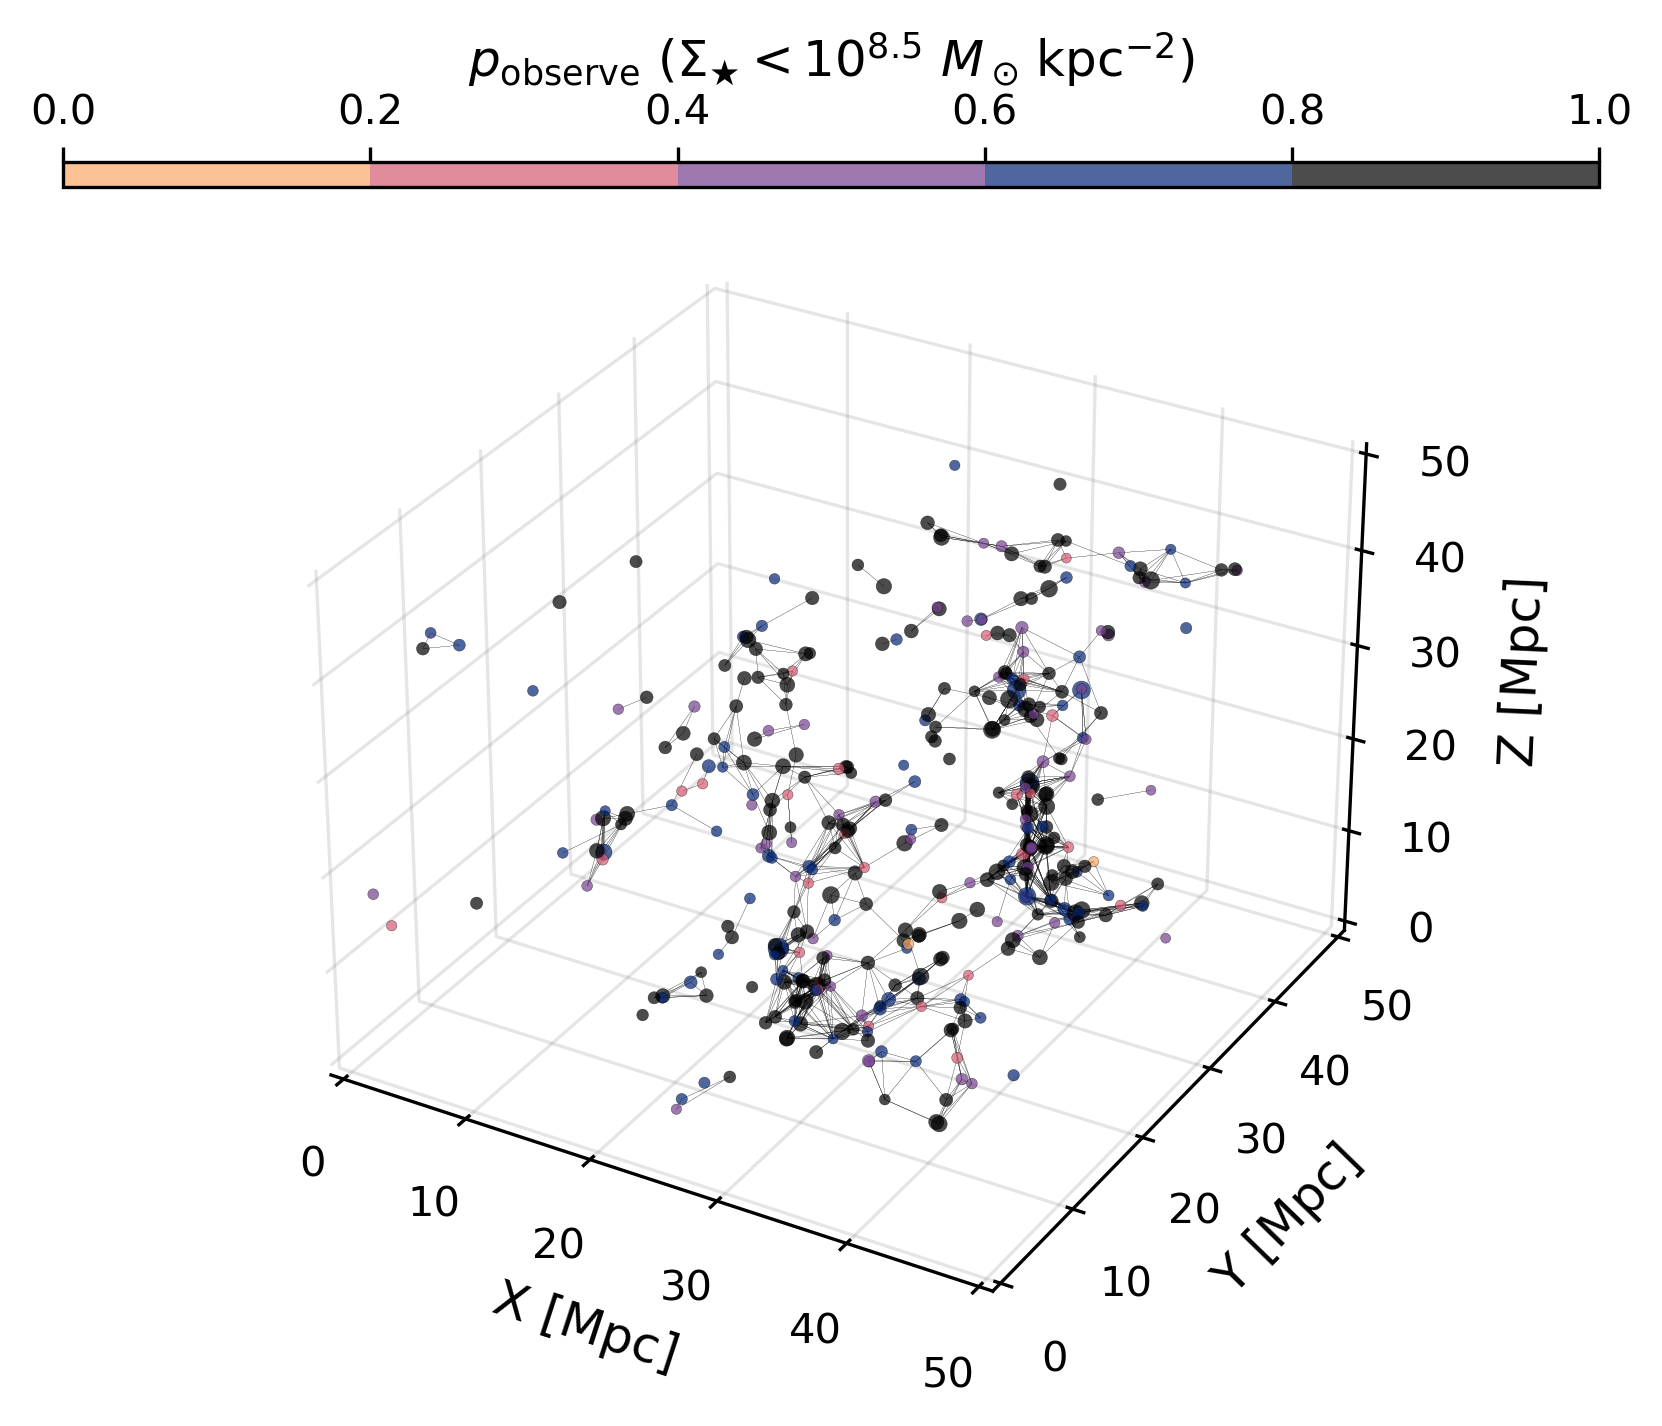

In [30]:
datum = data[-1]


fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(projection="3d", position=[0.05, 0.025, 0.6, 0.8])

fontsize = 12
pos = config_params["boxsize"]/2 /1e3 *datum.x[:,:3]


# compute dropout probability
sb_threshold = 8.5
sigmoid_width=0.3
sb = datum.x[:, -2] - 2 * np.log10(10**datum.x[:, -1] * normalization_params["norm_half_mass_radius"] * h) - np.log10(np.pi)
observe_prob = 1 / (1 + torch.exp((sb_threshold - sb) / sigmoid_width))
cmap = cmr.get_sub_cmap(cmr.torch_r, 0.2, 1, N=5)

mass = datum.x[:, -2]

# Draw lines for each edge

if datum.edge_index is not None:
    for (src, dst) in datum.edge_index.t().tolist():

        src = pos[src].tolist()
        dst = pos[dst].tolist()
        
        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.2/r_link, color='black')
        

# Plot nodes
sc = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=2**(mass-7.), zorder=1000, vmin=0, vmax=1, alpha=0.7, edgecolor='k', c=observe_prob, cmap=cmap, linewidths=0.1)
fig.subplots_adjust(left=0.1, right=0.9)

cb = fig.colorbar(sc, shrink=0.8, aspect=60, pad=0, location='top')
cb.set_label("$p_{\\rm observe}$ ($\\Sigma_\\bigstar < 10^{8.5}\  M_\\odot\,{\\rm kpc}^{-2}$)", fontsize=fontsize)

ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.xaxis.set_tick_params()
ax.yaxis.set_tick_params()
ax.set_xlabel("X [Mpc]", fontsize=fontsize)
ax.set_ylabel("Y [Mpc]", fontsize=fontsize)

ax.set_zlim(0, 50)
ax.zaxis.set_tick_params()
ax.set_zlabel("Z [Mpc]", fontsize=fontsize)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.yaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.zaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)


# Train GNN with dropout applied on the fly

In [23]:
def train_cosmic_gnn(
    data, k, 
    split=6, r_link=5, aggr="sum", use_loops=True, in_projection=False, 
    make_plots=True, results_path=None, apply_dropout=False,
    hidden_channels=256, latent_channels=128, n_layers=1
):
    """Trains GNN using global optimization params"""

    proj_str = "-projected" if in_projection else ""
    
    print(f"Begin training{proj_str}")
    
    
    gc.collect();
    print(f"Training fold {k+1}/{split}" + "\n")
    
    node_features = data[0].x.shape[1]
    out_features = data[0].y.shape[1]

    model = EdgePointGNN(
        node_features=node_features, 
        n_layers=n_layers, 
        D_link=r_link,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        loop=use_loops,
        estimate_all_subhalos=True,
        use_global_pooling=False,
        n_out=out_features,
        aggr=(["sum", "max", "mean"] if aggr == "multi" else aggr)
    )

    model.to(device);

    # assumes that data is a list of PyG Data objects, otherwise this will fail
    data_train = data[:k*train_test_frac_split] + data[(k+1)*train_test_frac_split:]
    data_valid = data[k*train_test_frac_split:(k+1)*train_test_frac_split]

    # apply_dropout
    if apply_dropout:
        data_train = list(
            map(
                partial(drop_low_surface_brightness, sb_threshold=8.5, sigmoid_width=0.03, rng=rng),
                data_train
            )
        )
        data_valid = list(
            map(
                partial(drop_low_surface_brightness, sb_threshold=8.5, sigmoid_width=0.03, rng=rng),
                data_valid
            )
        )

    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False)

    print("Epoch    train loss   valid loss   RMSE   avg std")

    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=training_params["learning_rate"], 
        weight_decay=training_params["weight_decay"]
    )

    train_losses = []
    valid_losses = []
    for epoch in range(training_params["n_epochs"]):

        # anneal at 25%, 50%, and 75%
        if (epoch == int(training_params["n_epochs"] * 0.5)):
            optimizer = torch.optim.AdamW(
                model.parameters(), 
                lr=training_params["learning_rate"] / 5, 
                weight_decay=training_params["weight_decay"] / 5
            )
        if (epoch == int(training_params["n_epochs"] * 0.75)):
            optimizer = torch.optim.AdamW(
                model.parameters(), 
                lr=training_params["learning_rate"] / 25, 
                weight_decay=training_params["weight_decay"] / 25
            )

        train_loss = train(train_loader, model, optimizer, device, in_projection=in_projection)
        valid_loss, valid_std, p, y, logvar_p  = validate(valid_loader, model, device, in_projection=in_projection)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)


        if (epoch + 1) % 10 == 0:
            print(f" {epoch + 1: >4d}      {train_loss: >6.2f}       {valid_loss: >6.2f}    {np.sqrt(np.mean((p - y.flatten())**2)): >6.3f}  {np.mean(valid_std): >6.3f}")

    if make_plots:
        plt.figure(figsize=(6, 3), dpi=150)
        plt.plot(train_losses, c=c0, label="Train")
        plt.plot(valid_losses, c=c3, label="Valid")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(alpha=0.15)
        if in_projection:
            plt.ylim(-9, -4)
        plt.ylim(-10, -4)
        plt.tight_layout()

        plt.savefig(f"{results_path}/training-logs/losses{proj_str}-fold{k+1}.png")

    if save_models:
        torch.save(
            model.state_dict(),
            f"{results_path}/models/EdgePointGNN-link{r_link}-hidden{hidden_channels}-latent{latent_channels}-selfloops{int(use_loops)}-agg{aggr}-epochs{training_params['n_epochs']}{proj_str}_fold{k+1}.pth", 
        )
        plt.close()
    return model

def validate_cosmic_gnn(
    model, data, k, 
    split=6, in_projection=False, apply_dropout=False,
    make_plots=True, results_path=None
):
    """Validates and compares GNN model against RF models"""
    data_train = data[:k*train_test_frac_split] + data[(k+1)*train_test_frac_split:]
    data_valid = data[k*train_test_frac_split:(k+1)*train_test_frac_split]

    if apply_dropout:
        data_train = list(
            map(
                partial(drop_low_surface_brightness, sb_threshold=8.5, sigmoid_width=0.03, rng=None),
                data_train
            )
        )
        data_valid = list(
            map(
                partial(drop_low_surface_brightness, sb_threshold=8.5, sigmoid_width=0.03, rng=None),
                data_valid
            )
        )

    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False)
    
    # actually validate model
    _, _, p_valid, y_valid, logvar_p = validate(valid_loader, model, device)
    p_valid = p_valid.reshape((-1, 1))
    p_log_Mhalo = p_valid[:, 0]
    y_log_Mhalo = y_valid[:, 0]
    log_Mstar = np.concatenate([d.x[:, -2] for d in data_valid])

    X_train = np.concatenate([d.x[:, -2] for d in data_train]).reshape((-1, 1))
    y_train = np.concatenate([d.y[:, 0] for d in data_train])

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    X_valid = np.concatenate([d.x[:, -2] for d in data_valid]).reshape((-1, 1))
    p_log_Mhalo_rf = rf.predict(X_valid)

    p_gnn_key = "p_GNN_2d" if in_projection else "p_GNN_3d" 
    df = pd.DataFrame({
        "log_Mstar": log_Mstar,
        "log_Mhalo": y_log_Mhalo,
        "p_RF": p_log_Mhalo_rf,
        p_gnn_key: p_log_Mhalo
    })
    proj_str = "-projected" if in_projection else ""
    df.to_csv(f"{results_path}/validation{proj_str}-fold{k+1}.csv", index=False)

In [24]:
class EdgePointLayer(MessagePassing):
    """Graphnet with point + edge layers.
    
    Very loosely inspired by https://github.com/PabloVD/HaloGraphNet.
    Initialized with `sum` aggregation, although `max` or others are possible.
    """
    def __init__(self, in_channels, mid_channels, out_channels, aggr='sum', use_mod=False):
        super(EdgePointLayer, self).__init__(aggr)

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3, or 1 if only modulus is used).
        self.mlp = nn.Sequential(
            nn.Linear(2 * in_channels - 2, mid_channels, bias=True),
            nn.LayerNorm(mid_channels),
            nn.ReLU(),
            nn.Linear(mid_channels, mid_channels, bias=True),
            nn.LayerNorm(mid_channels),
            nn.ReLU(),
            nn.Linear(mid_channels, out_channels, bias=True),
        )

        self.messages = 0.
        self.input = 0.
        self.use_mod = use_mod

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        """Message passing function:
            x_j defines the features of neighboring nodes as shape [num_edges, in_channels]
            pos_j defines the position of neighboring nodes as shape [num_edges, 3]
            pos_i defines the position of central nodes as shape [num_edges, 3]
        """

        pos_i, pos_j = x_i[:,:3], x_j[:,:3]

        input = pos_j - pos_i  # Compute spatial relation.
        input = input[:,0]**2.+input[:,1]**2 + input[:,2]**2.
        input = input.view(input.shape[0], 1)
        input = torch.cat([x_i, x_j[:, 3:], input], dim=-1)

        self.input = input
        self.messages = self.mlp(input)

        return self.messages

class EdgePointGNN(nn.Module):
    """Graph net over nodes and edges with multiple unshared layers, and sequential layers with residual connections.
    Self-loops also get their own MLP (i.e. galaxy-halo connection).
    """
    def __init__(self, node_features, n_layers, D_link, hidden_channels=64, aggr="sum", latent_channels=64, n_out=2, n_unshared_layers=4, loop=True, estimate_all_subhalos=True, use_global_pooling=True):
        super(EdgePointGNN, self).__init__()

        in_channels = node_features
        
        layers = [
            nn.ModuleList([
                EdgePointLayer(in_channels, hidden_channels, latent_channels, aggr=aggr)
                for _ in range(n_unshared_layers)
            ])
        ]
        for _ in range(n_layers-1):
            layers += [
                nn.ModuleList([
                    EdgePointLayer(3 * latent_channels * n_unshared_layers, hidden_channels, latent_channels, aggr=aggr) 
                    for _ in range(n_unshared_layers)
                ])
            ]
        self.n_out = n_out
        self.layers = nn.ModuleList(layers)
        self.estimate_all_subhalos = estimate_all_subhalos
        self.use_global_pooling = use_global_pooling

        n_pool = (len(aggr) if isinstance(aggr, list) else 1) 
        self.fc = nn.Sequential(
            (
                nn.Linear((n_unshared_layers * n_pool )* latent_channels, latent_channels, bias=True) if self.estimate_all_subhalos
                else nn.Linear(n_unshared_layers * latent_channels * 3, latent_channels, bias=True)
            ),
            nn.LayerNorm(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, 2 * n_out, bias=True)
        )
        
        self.galaxy_halo_mlp = nn.Sequential(
            nn.Linear(node_features, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, 2 * n_out, bias=True)
        )
        
        self.D_link = D_link
        self.loop = loop
        self.pooled = 0.
        self.h = 0.
    
    def forward(self, data):
        
        # determine edges by getting neighbors within radius defined by `D_link`
        edge_index = radius_graph(data.pos, r=self.D_link, batch=data.batch, loop=self.loop)

        x = torch.cat([unshared_layer(data.x, edge_index=edge_index) for unshared_layer in self.layers[0]], axis=1)
        self.h = x
        x = x.relu()
        
        for layer in self.layers[1:]:
            # use residual
            x = self.h + torch.cat([unshared_layer(x, edge_index=edge_index) for unshared_layer in layer], axis=1)
        
            self.h = x
            x = x.relu()
        
        # x = torch.concat([x, self.galaxy_halo_mlp(data.x)], axis=1)
        
        if self.estimate_all_subhalos:
            # returns all of the subhalos
            return self.fc(x) + self.galaxy_halo_mlp(data.x)
        else:
            import sys
            sys.exit()


In [25]:
def train(dataloader, model, optimizer, device, augment=True, in_projection=False, no_positions=False, no_velocities=False):
    """Assumes that data object in dataloader has 8 columns: x,y,z, vx,vy,vz, Mh, Vmax"""
    model.train()

    loss_total = 0
    for data in dataloader:

        
        if augment:
            # random rotation for data augmentation
            R = torch.tensor(Rotation.random().as_matrix(), dtype=torch.float32)
            if in_projection:
                data.pos = (R[:2, :2] @ data.pos.unsqueeze(-1)).squeeze()
                data.x[:, :2] = (R[:2, :2] @ data.x[:, :2].unsqueeze(-1)).squeeze()
            else:
                data.pos = (R @ data.pos.unsqueeze(-1)).squeeze()
                data.x[:, :3] = (R @ data.x[:, :3].unsqueeze(-1)).squeeze()
            
                # also augment velocities
                data.x[:, 3:6] = (R @ data.x[:, 3:6].unsqueeze(-1)).squeeze()

            # add random noise
            data_x_scatter = torch.std(data.x, dim=0)
            data_y_scatter = torch.std(data.y, dim=0)
            assert (data_x_scatter.shape[0] == len(data.x[0]))
            data.x += 1e-5 * data_x_scatter
            data.y += 1e-5 * data_y_scatter

        data.to(device)

        optimizer.zero_grad()
        y_pred, logvar_pred = model(data).chunk(2, dim=1)
        y_pred = y_pred.view(-1, model.n_out)
        logvar_pred = logvar_pred.view(-1, model.n_out)

        # compute loss as sum of two terms for likelihood-free inference
        if model.estimate_all_subhalos or (model.n_out > 1):
            loss_mse = F.mse_loss(y_pred, data.y)
            loss_lfi = F.mse_loss((y_pred - data.y)**2, 10**logvar_pred)
        else:
            loss_mse = F.mse_loss(y_pred.flatten(), data.y)
            loss_lfi = F.mse_loss((y_pred.flatten() - data.y)**2, 10**logvar_pred.flatten())
        loss = torch.log(loss_mse) + torch.log(loss_lfi)

        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    return loss_total / len(dataloader)

def validate(dataloader, model, device, in_projection=False, no_velocities=False, no_positions=False):
    model.eval()

    uncertainties = []
    loss_total = 0

    y_preds = []
    y_trues = []
    logvar_preds = []

    for data in dataloader:
        with torch.no_grad():
            data.to(device)
            y_pred, logvar_pred = model(data).chunk(2, dim=1)
            y_pred = y_pred.view(-1, model.n_out)
            logvar_pred = logvar_pred.view(-1, model.n_out)
            uncertainties.append(np.sqrt(10**logvar_pred.detach().cpu().numpy()).mean(-1))

            # compute loss as sum of two terms for likelihood-free inference
            if model.estimate_all_subhalos or (model.n_out > 1):
                loss_mse = F.mse_loss(y_pred, data.y)
                loss_lfi = F.mse_loss((y_pred - data.y)**2, 10**logvar_pred)
            else:
                loss_mse = F.mse_loss(y_pred.flatten(), data.y)
                loss_lfi = F.mse_loss((y_pred.flatten() - data.y)**2, 10**logvar_pred.flatten())
            loss = torch.log(loss_mse) + torch.log(loss_lfi)

            loss_total += loss.item()
            y_preds += list(y_pred.detach().cpu().numpy())
            y_trues += list(data.y.detach().cpu().numpy())
            logvar_preds += list(logvar_pred.detach().cpu().numpy())

    y_preds = np.concatenate(y_preds)
    y_trues = np.array(y_trues)
    logvar_preds = np.concatenate(logvar_preds)
    uncertainties = np.concatenate(uncertainties)

    return (
        loss_total / len(dataloader),
        np.mean(uncertainties, -1),
        y_preds,
        y_trues,
        logvar_preds
    )
    

In [26]:
apply_dropout = True
n_hidden = 128
n_latent = 64
n_layers = 1

aggr = "sum"
pad = r_link / 2


results_path = f"{ROOT}/results/predicting-Mhalo/dropout-lsb_{aggr}_loops-{int(use_loops)}/r_link{r_link}"

Path(f"{results_path}/data").mkdir(parents=True, exist_ok=True)
Path(f"{results_path}/training-logs").mkdir(parents=True, exist_ok=True)
Path(f"{results_path}/models").mkdir(parents=True, exist_ok=True)

for k in range(split): 
    model = train_cosmic_gnn(
        data, k=k, r_link=r_link, 
        aggr=aggr, use_loops=use_loops, split=split, 
        in_projection=in_projection, make_plots=make_plots, 
        results_path=results_path, apply_dropout=apply_dropout, 
        hidden_channels=n_hidden, latent_channels=n_latent, n_layers=n_layers
    )
    
    validate_cosmic_gnn(
        model, data, k=k, 
        split=split, in_projection=in_projection, 
        make_plots=make_plots, results_path=results_path, 
        apply_dropout=apply_dropout
    )

Begin training
Training fold 1/6

Epoch    train loss   valid loss   RMSE   avg std
   10       -3.31        -3.47     0.447   0.188
   20       -5.17        -5.08     0.377   0.463
   30       -5.67        -5.54     0.360   0.347
   40       -5.87        -5.99     0.325   0.344
   50       -6.08        -6.36     0.303   0.306
   60       -5.79        -6.38     0.301   0.273
   70       -6.16        -6.59     0.287   0.318
   80       -6.50        -6.67     0.288   0.254
   90       -6.47        -6.88     0.276   0.280
  100       -6.63        -6.51     0.301   0.240
  110       -6.64        -7.06     0.263   0.287
  120       -6.43        -6.65     0.265   0.013
  130       -5.97        -5.96     0.296   0.012
  140       -6.53        -6.78     0.258   0.014
  150       -6.36        -6.67     0.269   0.022
  160       -5.73        -4.74     0.395   0.071
  170       -6.02        -5.13     0.390   0.226
  180       -6.95        -7.12     0.260   0.230
  190       -7.00        -7.17    

## Examine validation outputs

In [27]:
def combine_results(split=6, centrals=None, results_path=None):
    """Combine all results, including 3d and 2d GNN"""
    results = []
    for k in range(split):
        valid_k = pd.read_csv(f"{results_path}/validation-fold{k+1}.csv")
        # valid_proj_k = pd.read_csv(f"{results_path}/validation-projected-fold{k+1}.csv", usecols=["p_GNN_2d"])
        
        # valid_k["p_GNN_2d"] = valid_proj_k
        results.append(valid_k)
    
    results = pd.concat(results, axis=0, ignore_index=True)
    
    if centrals is not None:
        results["is_central"] = centrals
    results.to_csv(f"{results_path}/cross-validation.csv", index=False)
    
    return results
    
results = combine_results(split=split, centrals=None, results_path=results_path)

In [34]:
binned_statistic(x=results.log_Mhalo, values=results.p_GNN_3d, statistic=partial(np.percentile, q=50), bins=np.arange(11.5, 15.5, 0.5), )

BinnedStatisticResult(statistic=array([11.6632405, 12.0451485, 12.5312405, 13.080558 , 13.61577  ,
       14.117506 , 14.401125 ]), bin_edges=array([11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ]), binnumber=array([2, 1, 5, ..., 0, 0, 0]))

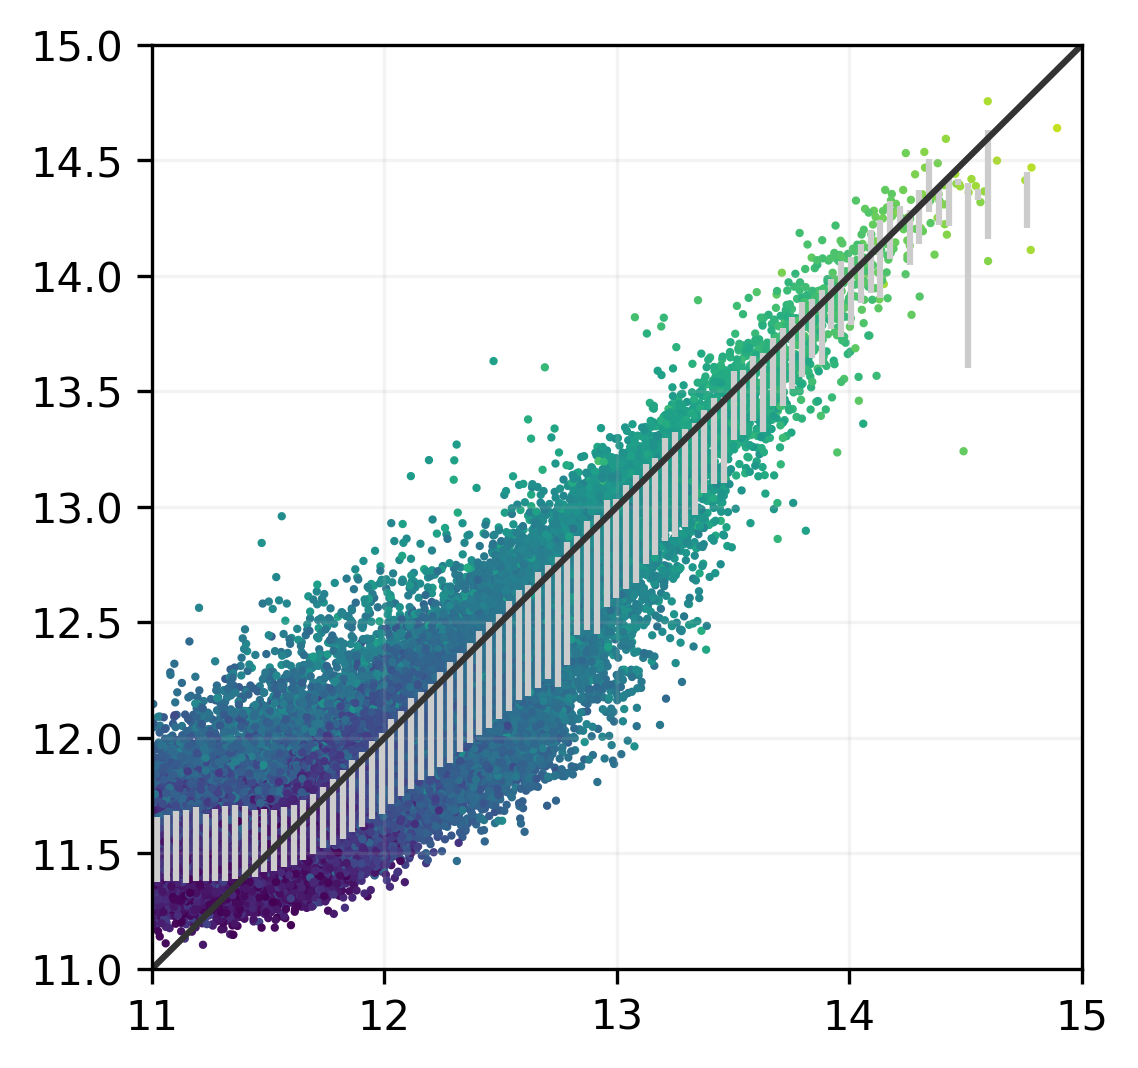

In [42]:
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(results.log_Mhalo, results.p_GNN_3d, c=results.log_Mstar, s=1)

stat = binned_statistic(x=results.log_Mhalo, values=results.p_GNN_3d, statistic=partial(np.percentile, q=50), bins=100)

bins = (stat.bin_edges[1:] + stat.bin_edges[:-1]) / 2
p50 = stat.statistic
p84 = binned_statistic(x=results.log_Mhalo, values=results.p_GNN_3d, statistic=partial(np.percentile, q=84), bins=100).statistic
p16 = binned_statistic(x=results.log_Mhalo, values=results.p_GNN_3d, statistic=partial(np.percentile, q=16), bins=100).statistic

plt.errorbar(bins, p50, [p50-p16, p84-p50], ls='', c='0.8')

plt.plot([11, 15], [11, 15], c="0.2")
plt.xlim(11, 15)
plt.ylim(11, 15)
plt.grid(alpha=0.15)

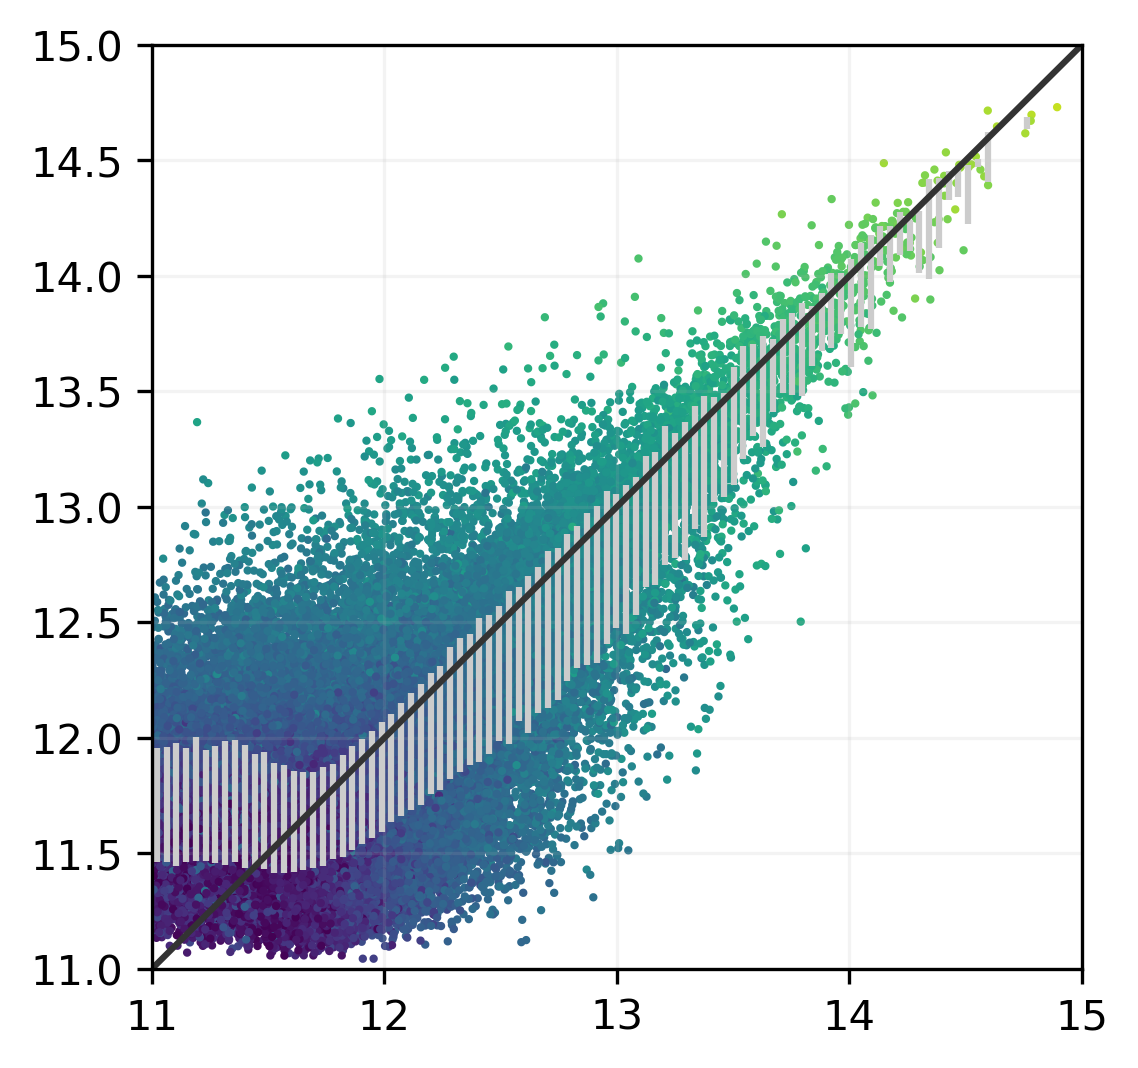

In [52]:
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(results.log_Mhalo, results.p_RF, c=results.log_Mstar, s=1)

stat = binned_statistic(x=results.log_Mhalo, values=results.p_RF, statistic=partial(np.nanpercentile, q=50), bins=100)

bins = (stat.bin_edges[1:] + stat.bin_edges[:-1]) / 2
p50 = stat.statistic
p84 = binned_statistic(x=results.log_Mhalo, values=results.p_RF, statistic=partial(np.nanpercentile, q=84), bins=100).statistic
p16 = binned_statistic(x=results.log_Mhalo, values=results.p_RF, statistic=partial(np.nanpercentile, q=16), bins=100).statistic
plt.errorbar(bins, p50, [p50-p16, p84-p50], ls='', c='0.8')


plt.plot([11, 15], [11, 15], c="0.2")
plt.xlim(11, 15)
plt.ylim(11, 15)
plt.grid(alpha=0.15)

# ...